In [1]:
from datetime import datetime
import json
import os
import shutil

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib import rc
from mots_vides import stop_words
import pygit2
from wordcloud import WordCloud

mots_creux = stop_words('fr')

In [2]:
repo = (
    pygit2.Repository('data.git')
    if os.path.exists('data.git')
    else pygit2.clone_repository('https://framagit.org/paula.forteza/data-consultation-reforme-assemblee.git', 'data.git', bare=True)
    )

In [3]:
comment_by_id = {}
replies_by_comment_id = {}
scores_by_comment_id = {}
for commit in repo.walk(repo.head.target, pygit2.GIT_SORT_TOPOLOGICAL  | pygit2.GIT_SORT_REVERSE):
    # print(datetime.fromtimestamp(commit.commit_time))
    for entry in commit.tree:
        if entry.type == 'tree':
            # print(entry.id, entry.type, entry.name)
            topic_tree = repo[entry.id]
            topic_blob = repo[topic_tree['topic.json'].id]
            topic = json.loads(topic_blob.data)
            # print()
            # print(topic['mediaTitle'])
            comments_tree = repo[topic_tree['comments'].id]
            for comment_entry in comments_tree:
                comment_blob = repo[comment_entry.id]
                comment = json.loads(comment_blob.data)
                # print('----')
                # print(comment['text'])
                comment_by_id[comment['id']] = comment
                replies_by_comment_id.setdefault(comment['id'], []).append((commit.commit_time, comment['repliesCount']))
                scores_by_comment_id.setdefault(comment['id'], []).append((commit.commit_time, comment['score']))

In [4]:
label_by_comment_id = {
    '59f7251ae8a9656c1a8e7390': "Référendum d’initiative citoyenne",
    '59f72ac8e8a9656c1a8e73a9': "Assemblée constituante tirée au sort",
    '59de1a2866914e1e82238150': "Question citoyenne au gouvernement",
    '59db7d979e1c7be85124ddce': "Pétition > 100 000",
    '59dc72b49e1c7be85124e1f5': "Pédagogie des lois et de leurs processus",
    '59e3c9f166914e1e822387d5': "Pétitions comme en Suisse",
    '59e6681e66914e1e82238c7f': "Assemblée hors les murs",
    '59db7c979e1c7be85124ddbd': "Plateforme de consultation officielle",
    '59ebb2e966914e1e822395f4': "Votations et référendums obligatoires",
    '59db808a9e1c7be85124dde0': "Scrutins au jugement majoritaire",
    '59db8cd49e1c7be85124deb0': "Référendums d'initiative populaire et locaux",
    '59e8c9a766914e1e822390fa': "Référendum révocatoire",
    '59e31ef666914e1e822386a0': "Débats plutôt que référendums",
    '59db85cf9e1c7be85124de62': "Changement de constitution",
    }


In [5]:
comments_sorted_by_score = sorted(
    scores_by_comment_id.items(),
    key = lambda comment_id_and_scores: comment_id_and_scores[1][-1][1],
    reverse=True,
    )

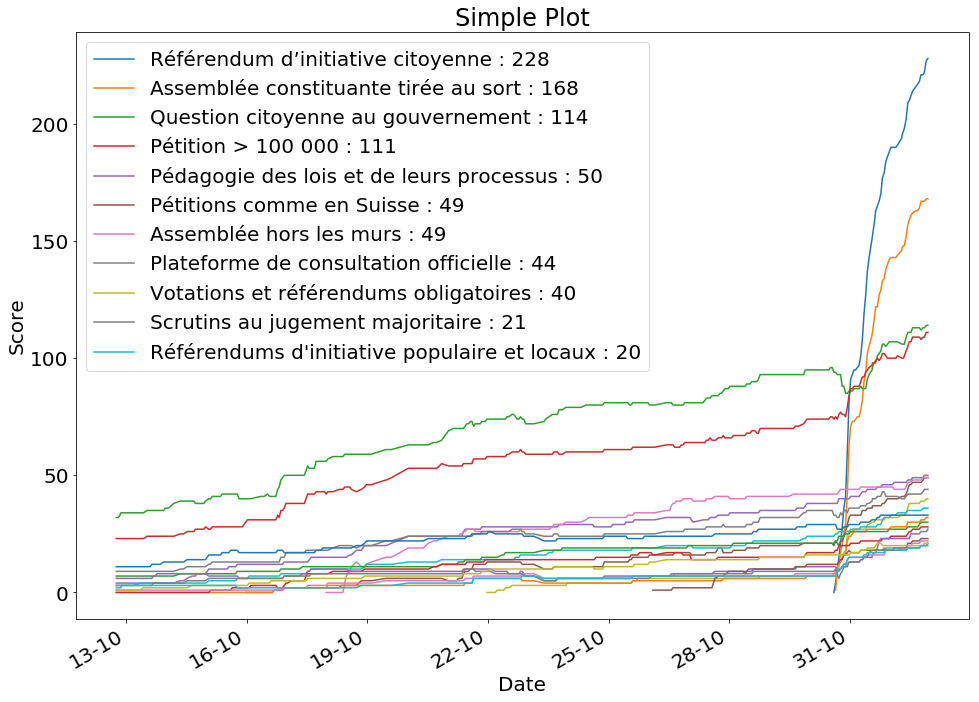

In [6]:
def get_label_with_score(comment_id):
    label = label_by_comment_id.get(comment_id)
    if label is None:
        return None
    scores = scores_by_comment_id[comment_id]
    return '{} : {}'.format(label, scores[-1][1])

rc('font', size=20)

figure, axes = plt.subplots(1, figsize=(16, 12))
figure.autofmt_xdate()

for comment_id, scores in comments_sorted_by_score[:20]:
    x = [
        datetime.fromtimestamp(epoch)
        for epoch, score in scores
        ]
    y = [
        score
        for period, score in scores
        ]
    plt.plot(x, y, label=get_label_with_score(comment_id))

plt.xlabel('Date')
plt.ylabel('Score')

plt.title('Simple Plot')
x_formatter = mdates.DateFormatter('%d-%m')
axes.xaxis.set_major_formatter(x_formatter)
plt.legend()

plt.show()

In [7]:
for comment_id, scores in comments_sorted_by_score[:10]:
    comment = comment_by_id[comment_id]
    print('\n----------------- {} - {} - Score : {}\n'.format(comment_id, comment['author']['displayName'], scores[-1][1]))
    print(comment['text'])


----------------- 59f7251ae8a9656c1a8e7390 - Article 3 - Score : 228

Instauration du Référendum d’Initiative Citoyenne :
En démocratie, le peuple doit être le législateur en dernier ressort. Seul le référendum d'initiative citoyenne nous permettra de reprendre la parole pour décider de ce qui nous regarde, et ainsi de devenir pleinement citoyens.
  
Nous vous proposons une nouvelle formulation de l’article 3 de la Constitution : 
“La souveraineté nationale appartient au peuple qui l’exerce par ses représentants et par la voie du référendum d’initiative citoyenne en toutes matières, y compris constitutionnelle et de ratification des traités. Cet article ne peut être modifié que par voie référendaire.” 
 
(En savoir plus : http://www.article3.fr/informations/definition-du-ric)

----------------- 59f72ac8e8a9656c1a8e73a9 - Le Démocrate - Score : 168

Convocation d’une Assemblée Constituante Tirée Au Sort :
Parce que ce n’est pas aux hommes au pouvoir d’écrire les règles du pouvoir, nous

In [8]:
comments_sorted_by_replies = sorted(
    replies_by_comment_id.items(),
    key = lambda comment_id_and_replies: comment_id_and_replies[1][-1][1],
    reverse=True,
    )

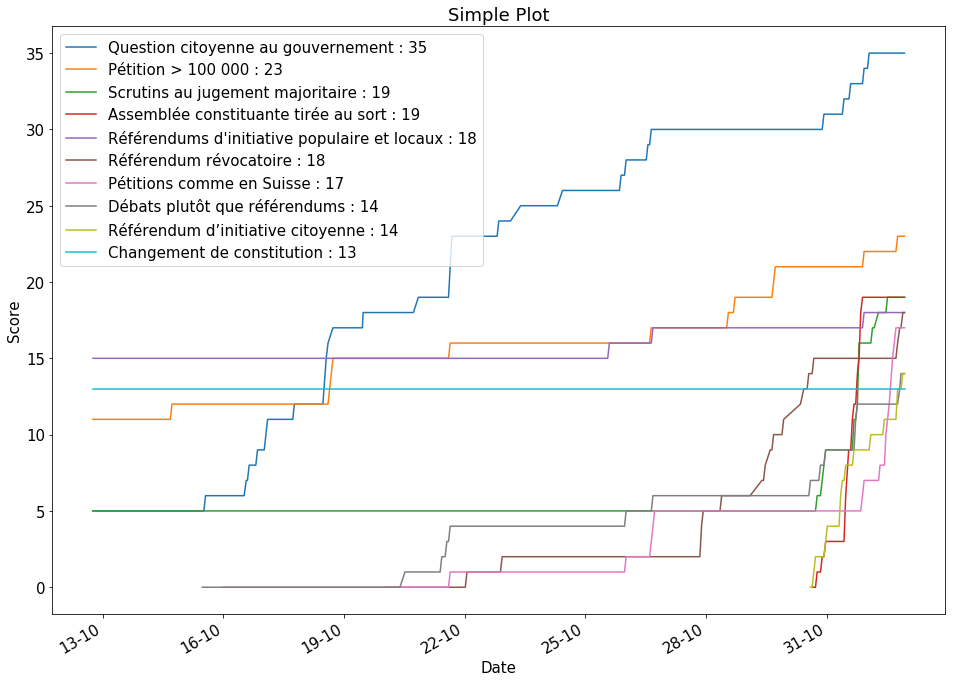

In [9]:
def get_label_with_replies_count(comment_id):
    label = label_by_comment_id.get(comment_id)
    if label is None:
        return None
    replies = replies_by_comment_id[comment_id]
    return '{} : {}'.format(label, replies[-1][1])

rc('font', size=15)

figure, axes = plt.subplots(1, figsize=(16, 12))
figure.autofmt_xdate()

for comment_id, scores in comments_sorted_by_replies[:10]:
    x = [
        datetime.fromtimestamp(epoch)
        for epoch, score in scores
        ]
    y = [
        score
        for period, score in scores
        ]
    plt.plot(x, y, label=get_label_with_replies_count(comment_id))

plt.xlabel('Date')
plt.ylabel('Score')

plt.title('Simple Plot')
x_formatter = mdates.DateFormatter('%d-%m')
axes.xaxis.set_major_formatter(x_formatter)
plt.legend()

plt.show()

In [10]:
for comment_id, replies in comments_sorted_by_replies[:10]:
    comment = comment_by_id[comment_id]
    print('\n----------------- {} - {} - Réponses : {}\n'.format(comment_id, comment['author']['displayName'], replies[-1][1]))
    print(comment['text'])


----------------- 59de1a2866914e1e82238150 - Axel Dauchez - Réponses : 35

LA QUESTION CITOYENNE AU GOUVERNEMENT :
Il faut que, chaque semaine à l'Assemblée nationale, les citoyens puissent poser une question au Gouvernement.

----------------- 59db7d979e1c7be85124ddce - Romain Riboldi - Réponses : 23

Obligation pour l’Assemblée nationale d’étudier une pétition dès qu’elle atteint 100 000 signataires comme en Grande-Bretagne.
 Organisateurs et organisatrices de la pétition doivent être invités à l’Assemblée nationale pour être écouté en audition et travailler dans les commissions en rapport avec la pétition.

----------------- 59db808a9e1c7be85124dde0 - David Libeau - Réponses : 19

# Adopter le jugement majoritaire comme mode de scrutin.

Depuis de nombreuses années l'abstention progresse à chaque élection. Un sentiment d'éloignement de la vie publique ou une remise en question de nos institutions démocratiques sont des raisons qui traduisent souvent un sentiment de **l'inutilité du

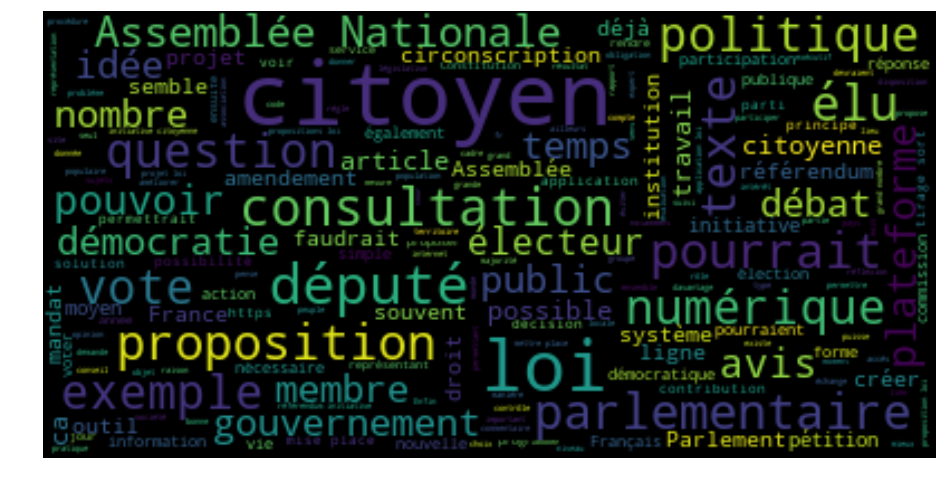

In [11]:
texts = []
for comment_id, replies in comments_sorted_by_score:
    comment = comment_by_id[comment_id]
    text = comment['text']
    texts.append(text)
    #wordcloud = WordCloud().generate(text)
    #plt.imshow(wordcloud, interpolation='bilinear')
    #plt.axis("off")

text = mots_creux.rebase('\n'.join(texts), '')

wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure(figsize=(16, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

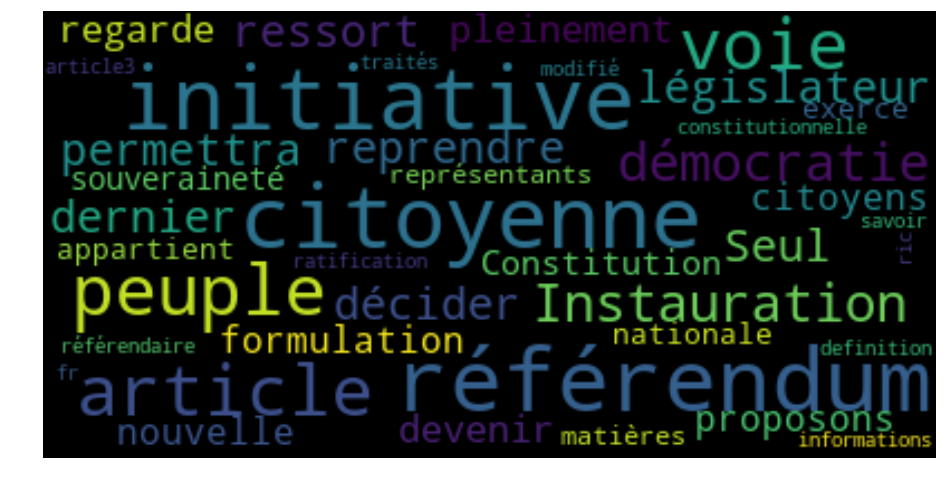

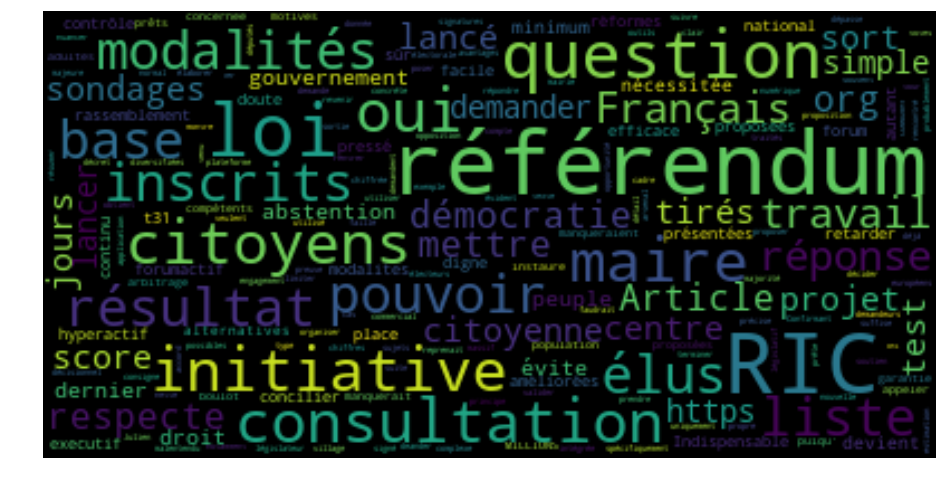

In [12]:
for comment_id, replies in comments_sorted_by_score[:1]:
    comment = comment_by_id[comment_id]
    text = comment['text']
    #wordcloud = WordCloud().generate(text)
    #plt.imshow(wordcloud, interpolation='bilinear')
    #plt.axis("off")

    text = mots_creux.rebase(text, '')

    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure(figsize=(16, 12))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    texts = []
    for reply in comment['replies']:
        text = reply['text']
        texts.append(text)
        #wordcloud = WordCloud().generate(text)
        #plt.imshow(wordcloud, interpolation='bilinear')
        #plt.axis("off")

    text = mots_creux.rebase('\n'.join(texts), '')

    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure(figsize=(16, 12))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()